In [1]:
!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

In [4]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

Shape: torch.Size([3, 223, 320]), Dtype: torch.float32
Shape: torch.Size([3, 375, 500]), Dtype: torch.float32


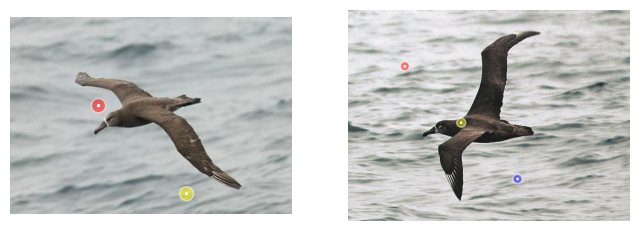

In [5]:
# This is the test code for above two functions : draw_correspondences and imsc
# It should display two images with points marked on them.
from PIL import Image
import matplotlib.pyplot as plt

# You should change the file path to your own file path
image1 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg')
image2 = Image.open('D:\\Github\\02456_Deep_Learning_Project\\data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg')

# check the file path
# image1.show()
# image2.show()

image1_tensor = pil_to_tensor(image1).float()  # convert to tensor
image2_tensor = pil_to_tensor(image2).float()

print(f"Shape: {image1_tensor.shape}, Dtype: {image1_tensor.dtype}")
print(f"Shape: {image2_tensor.shape}, Dtype: {image2_tensor.dtype}")

points1 = [(100, 100), (200, 200), (300, 300)]
points2 = [(100, 100), (200, 200), (300, 300)]


fig = draw_correspondences(points1, points2, image1_tensor, image2_tensor)

plt.show()


In [ ]:
#@title create dataset


from transformers import AutoProcessor, CLIPProcessor


# CLIP Model for image, pre-processing
# processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# Load the parts file, remember to change the path to your own path
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r', encoding='utf-8') as f:
    parts = [line.strip() for line in f.readlines()]


class CUB(Dataset):
    def __init__(self, base_path, train=True):

        self.base_path = base_path

        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']), header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']), header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']), header=None, sep=" ")

        self.transforms = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

        if train:
          mask = self.train_test_split.is_train.values == 1
        else:
          mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):

        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


variable x: tensor([[[ 0.8792,  0.7771,  0.8355,  ..., -0.0842, -0.0842,  0.0763],
         [ 0.8938,  0.8063,  0.8501,  ..., -0.1718, -0.0842, -0.0405],
         [ 0.7771,  0.8209,  0.9376,  ..., -0.2302, -0.0988, -0.2010],
         ...,
         [ 0.2515,  0.3829,  0.2223,  ..., -0.4638, -0.2886, -0.1572],
         [ 0.2661,  0.3245,  0.3537,  ..., -0.4784, -0.4930, -0.5806],
         [ 0.2515,  0.3537,  0.2953,  ..., -0.5952, -0.5222, -0.4638]],

        [[ 2.0149,  2.0299,  2.0449,  ...,  0.4691,  0.6491,  0.7242],
         [ 2.0299,  2.0299,  2.0149,  ...,  0.4390,  0.5291,  0.6942],
         [ 2.0449,  2.0449,  2.0149,  ...,  0.4390,  0.4841,  0.5441],
         ...,
         [ 0.7392,  0.6491,  0.6191,  ...,  0.4240,  0.5891,  0.8442],
         [ 0.7392,  0.7692,  0.6792,  ...,  0.3490,  0.3340,  0.4691],
         [ 0.7692,  0.7542,  0.7692,  ...,  0.3340,  0.3490,  0.3490]],

        [[ 0.8661,  0.9514,  0.9088,  ..., -0.2146, -0.0582,  0.0982],
         [ 0.8377,  0.8945,  0.93

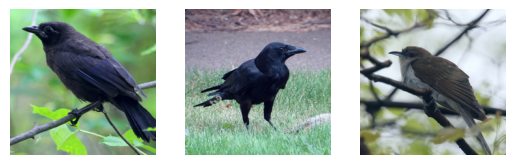

In [7]:
#@title dataset and dataloader and load samples

import random

# base_path = 'drive/MyDrive/CoSegXAI/datasets/cub200/CUB_200_2011/CUB_200_2011/' # You need to change this.
base_path = '../data/CUB_200_2011/' # You need to change this.

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

random.seed(30)
inputs, labels = [], []
data_indices = []
#data_indices = random.sample(range(train_dataset.__len__()), 10)
# Here is where we pick the images to analyse. It is smart to pick one image from the same class and one from a different class.
# That generally gives more interesting results. The data is ordered, so class 1 starts from indices (0-30), class 2 from (30-60)
# and so on.

data_indices.append(856)
data_indices.append(858)
data_indices.append(924)


for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)
  print(f"variable x: {x}")
  print(f"variable y: {y}")

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)

print(labels)

plt.figure(1)
plt.subplot(131)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(132)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(133)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.show()


In [8]:
#@title load model

from transformers import CLIPVisionConfig, CLIPVisionModel, CLIPModel

# You can use the CLIPTextModel to process the text data once you get that far.
# see https://huggingface.co/docs/transformers/model_doc/clip#transformers.TFCLIPTextModel
# for more information.
# configuration = CLIPVisionConfig()
# model = CLIPVisionModel(configuration).to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')


# text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')


inpus: [tensor([[[ 0.8792,  0.7771,  0.8355,  ..., -0.0842, -0.0842,  0.0763],
         [ 0.8938,  0.8063,  0.8501,  ..., -0.1718, -0.0842, -0.0405],
         [ 0.7771,  0.8209,  0.9376,  ..., -0.2302, -0.0988, -0.2010],
         ...,
         [ 0.2515,  0.3829,  0.2223,  ..., -0.4638, -0.2886, -0.1572],
         [ 0.2661,  0.3245,  0.3537,  ..., -0.4784, -0.4930, -0.5806],
         [ 0.2515,  0.3537,  0.2953,  ..., -0.5952, -0.5222, -0.4638]],

        [[ 2.0149,  2.0299,  2.0449,  ...,  0.4691,  0.6491,  0.7242],
         [ 2.0299,  2.0299,  2.0149,  ...,  0.4390,  0.5291,  0.6942],
         [ 2.0449,  2.0449,  2.0149,  ...,  0.4390,  0.4841,  0.5441],
         ...,
         [ 0.7392,  0.6491,  0.6191,  ...,  0.4240,  0.5891,  0.8442],
         [ 0.7392,  0.7692,  0.6792,  ...,  0.3490,  0.3340,  0.4691],
         [ 0.7692,  0.7542,  0.7692,  ...,  0.3340,  0.3490,  0.3490]],

        [[ 0.8661,  0.9514,  0.9088,  ..., -0.2146, -0.0582,  0.0982],
         [ 0.8377,  0.8945,  0.9372, 

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


outputs: BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.4483,  0.4068, -0.0084,  ...,  0.1377,  0.0650,  0.2317],
         [ 0.6779,  0.5720, -0.2643,  ..., -0.0188,  0.5886,  0.3208],
         [ 0.7861,  0.1758, -0.1297,  ...,  0.1787,  0.4247,  0.0823],
         ...,
         [ 0.1773, -0.1176, -0.2524,  ...,  0.4206, -0.0080,  0.2261],
         [ 0.0905, -0.0189, -0.1798,  ...,  0.4252,  0.0836,  0.1973],
         [ 0.2480, -0.0562, -0.1392,  ...,  0.3428,  0.2795,  0.2487]]],
       device='cuda:0', grad_fn=<AddBackward0>), pooler_output=tensor([[ 1.9653e+00,  1.2817e+00,  1.3585e-01,  2.1611e-01,  9.9167e-01,
         -6.2022e-01,  1.2973e+00, -4.3974e-01, -1.4416e-01,  4.2610e-01,
         -1.0121e+00,  7.3746e-01, -2.2383e-01,  4.5463e-01,  9.6996e-02,
          2.5474e-01, -7.2645e+00,  1.0713e+00,  2.3167e-01,  5.1835e-01,
         -5.9968e-01, -8.9622e-01, -1.0003e-01,  1.2831e+00, -6.9608e-01,
          1.1235e+00, -4.5208e-01, -3.0583e-01, -1.7756e-01,  5.3559e-0

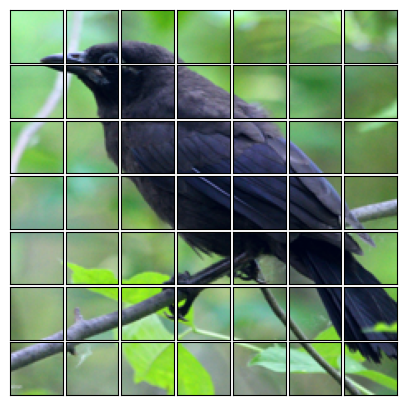

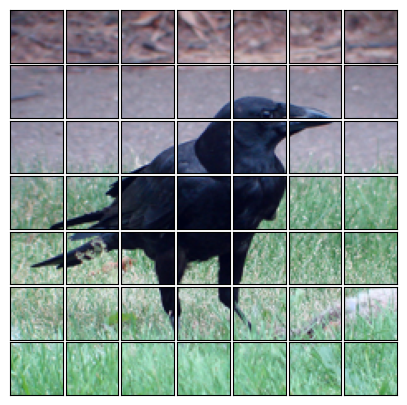

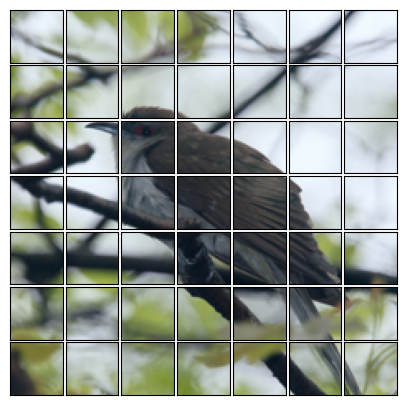

In [9]:
#@title plot patches

print(f"inpus: {inputs}")
for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    # original permute(0,1,2) -> (C,H,W)
    print(f"img shape before: {img.shape}")
    img = img.permute(1, 2, 0)
    print(f"img shape after: {img.shape}")
    

    H, W, C = img.shape
    # new shape (H, W, C)
    print(f"img shape: {img.shape}")

    # create a random tensor with the same shape as the input image, batch size 1
    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    # dummy_input = img.unsqueeze(0).to('cuda')

    outputs = model(dummy_input)  # 增加 batch 维度
    # outputs = model(pixel_values=img.unsqueeze(0).to('cuda'))  # 增加 batch 维度
    print(f"outputs: {outputs}")

    # 256 patches, 1024 features
    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size
    print("patch size is: ", PATCH_SIZE)
    # patch_width = 14
    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width
    # n_rows = 16, n_cols = 16

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]
    print(f"cropped_img shape: {cropped_img.shape}")
    

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    # create pathes 
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)



input shape: torch.Size([1, 3, 224, 224])
embedding shape: (49, 768)
input shape: torch.Size([1, 3, 224, 224])
embedding shape: (49, 768)
input shape: torch.Size([1, 3, 224, 224])
embedding shape: (49, 768)
['back', 'beak', 'belly', 'breast', 'crown', 'forehead', 'left eye', 'left leg', 'left wing', 'nape', 'right eye', 'right leg', 'right wing', 'tail', 'throat', 'background', 'blue wings', 'brown wings', 'iridescent wings', 'purple wings', 'rufous wings', 'grey wings', 'yellow wings', 'olive wings', 'green wings', 'pink wings', 'orange wings', 'black wings', 'white wings', 'red wings', 'buff wings', 'blue upperparts', 'brown upperparts', 'iridescent upperparts', 'purple upperparts', 'rufous upperparts', 'grey upperparts', 'yellow upperparts', 'olive upperparts', 'green upperparts', 'pink upperparts', 'orange upperparts', 'black upperparts', 'white upperparts', 'red upperparts', 'buff upperparts', 'blue underparts', 'brown underparts', 'iridescent underparts', 'purple underparts', 'ru

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


hidden state size : 768
last_hidden_state: torch.Size([128, 7, 768])
pooled_output: torch.Size([128, 768])
Parts embeddings shape: torch.Size([128, 768])
Patch embedding shape: torch.Size([49, 768])
Similarity matrix shape: torch.Size([49, 128])
Best match indices : tensor([  5, 102,   5,   5, 108,  30,   5,  21, 106,  25,  21,   5,   8,   5,
          5,  21,  21,  21,  21,  21,   5,   5, 108,  21, 116,  21,  21,   5,
          5, 102,   5,  30,   8,  21,  12,  24,   5,   5,  30,   5,   8,  21,
          5,  28,   5,   8,   8,   5,  30], device='cuda:0')
Best match indices shape: torch.Size([49])
Patch embedding shape: torch.Size([49, 768])
Similarity matrix shape: torch.Size([49, 128])
Best match indices : tensor([  5, 103, 103,   5, 104, 103,   5, 105, 104,   8,   8, 106, 106, 105,
          8,  31, 122,  25,  25,   5,   8,  28,  21, 116,  25,  25,   8,   8,
          5,   8,  12,  12,  12,  28,  28,  28,  28,  67,  30,  30,  30, 102,
         30,  30, 104,   5,  30,  30, 104], devi

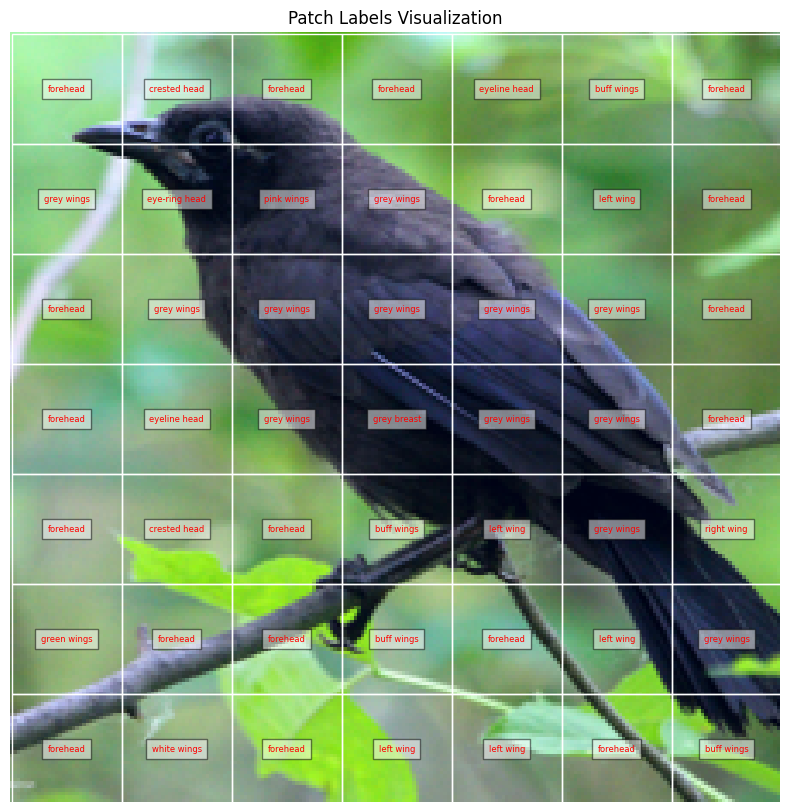

Visualizing Image 1...
Number of patches: 49
Number of labels: 49
Patches coordinates: [(0, 0), (32, 0), (64, 0), (96, 0), (128, 0), (160, 0), (192, 0), (0, 32), (32, 32), (64, 32), (96, 32), (128, 32), (160, 32), (192, 32), (0, 64), (32, 64), (64, 64), (96, 64), (128, 64), (160, 64), (192, 64), (0, 96), (32, 96), (64, 96), (96, 96), (128, 96), (160, 96), (192, 96), (0, 128), (32, 128), (64, 128), (96, 128), (128, 128), (160, 128), (192, 128), (0, 160), (32, 160), (64, 160), (96, 160), (128, 160), (160, 160), (192, 160), (0, 192), (32, 192), (64, 192), (96, 192), (128, 192), (160, 192), (192, 192)]
Labels: ['forehead', 'masked head', 'masked head', 'forehead', 'unique head', 'masked head', 'forehead', 'eyebrow head', 'unique head', 'left wing', 'left wing', 'eye-ring head', 'eye-ring head', 'eyebrow head', 'left wing', 'blue upperparts', 'black breast', 'pink wings', 'pink wings', 'forehead', 'left wing', 'white wings', 'grey wings', 'grey breast', 'pink wings', 'pink wings', 'left win

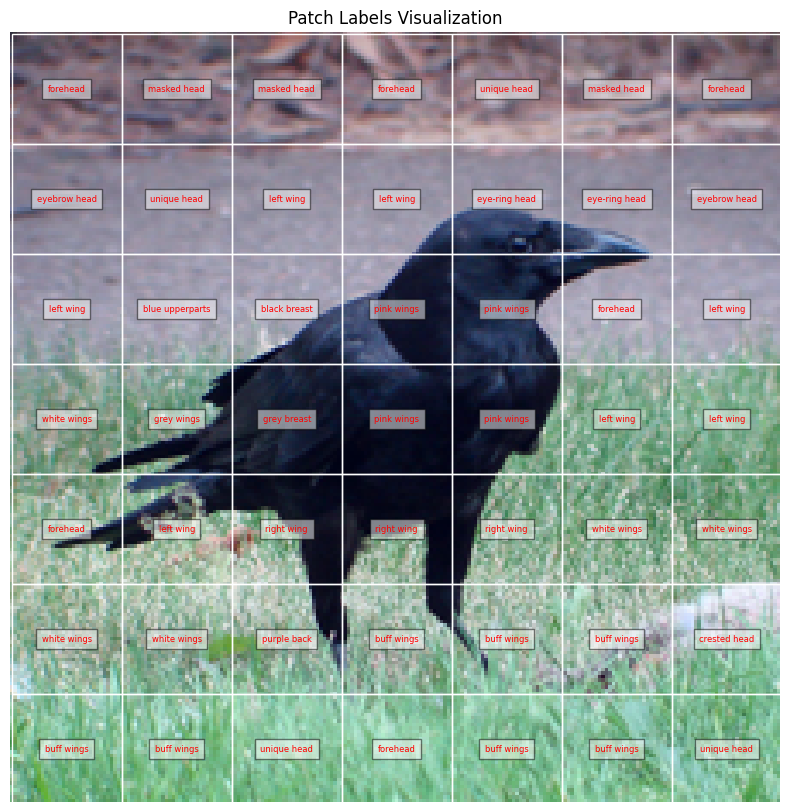

Visualizing Image 2...
Number of patches: 49
Number of labels: 49
Patches coordinates: [(0, 0), (32, 0), (64, 0), (96, 0), (128, 0), (160, 0), (192, 0), (0, 32), (32, 32), (64, 32), (96, 32), (128, 32), (160, 32), (192, 32), (0, 64), (32, 64), (64, 64), (96, 64), (128, 64), (160, 64), (192, 64), (0, 96), (32, 96), (64, 96), (96, 96), (128, 96), (160, 96), (192, 96), (0, 128), (32, 128), (64, 128), (96, 128), (128, 128), (160, 128), (192, 128), (0, 160), (32, 160), (64, 160), (96, 160), (128, 160), (160, 160), (192, 160), (0, 192), (32, 192), (64, 192), (96, 192), (128, 192), (160, 192), (192, 192)]
Labels: ['forehead', 'plain head', 'eyeline head', 'blue back', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'forehead', 'yellow wings', 'grey wings', 'grey breast', 'forehead', 'forehead', 'forehead', 'pink wings', 'crested head', 'grey breast', 'grey wings', 'grey wings', 'forehead', 'masked head', 'mask

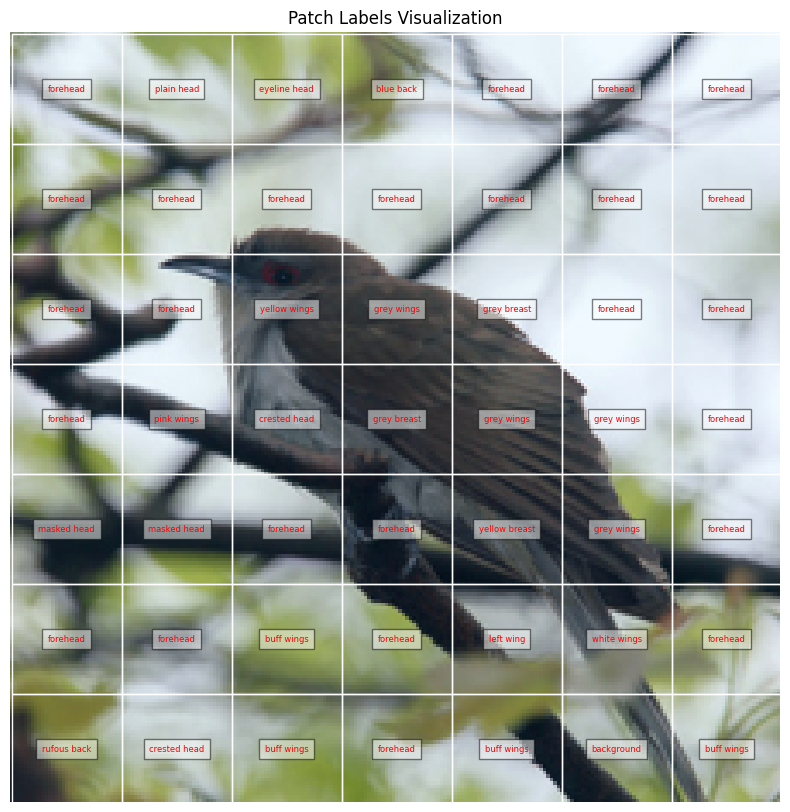

In [10]:
#@title create patch embeddings

device='cuda'

embedings = []

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)
        print(f"input shape:", input_i.shape)
        # vision model with input image
        outputs = model(input_i, output_attentions=False, output_hidden_states=True)
        # Extract and normalize the last_hidden_state
        last_hidden_state = outputs.last_hidden_state
        last_hidden_state = nn.functional.normalize(last_hidden_state, p=2, dim=-1)
        # last_hidden_state: (batch_size, sequence_length, hidden_size)
        embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))
        
        print(f"embedding shape:",embedings[counter].shape)

# Load the parts file
parts_file = '../data/CUB_200_2011/parts/parts.txt'
with open(parts_file, 'r', encoding='utf-8') as f:
    parts = [line.strip() for line in f.readlines()]
    
print(parts)

from transformers import AutoTokenizer, CLIPTextModel
from torch.nn.functional import cosine_similarity

# new_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
new_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

print(f"hidden state size :", new_model.config.hidden_size) 

text_inputs = tokenizer(parts, padding=True, return_tensors="pt")
new_outputs = new_model(**text_inputs)
new_last_hidden_state = new_outputs.last_hidden_state     
# normalize the last_hidden_state
new_last_hidden_state = nn.functional.normalize(new_last_hidden_state, p=2, dim=-1)
new_pooled_output = new_outputs.pooler_output.to(device)  

print("last_hidden_state:", new_last_hidden_state.shape)  
print("pooled_output:", new_pooled_output.shape)          

device = 'cuda'

# projection_layer = torch.nn.Linear(1024, 512).to(device)
# projection_layer = torch.nn.Sequential(
#     torch.nn.Linear(1024, 512),
#     # torch.nn.Linear(768, 512),
#     torch.nn.ReLU(), # sets negative values to zero
#     torch.nn.Linear(512, 512)
# ).to(device)
# parts_embeddings = projection_layer(new_pooled_output) # Shape: 

# Convert text embeddings to tensor
parts_embeddings = new_pooled_output  # Shape: (num_parts, 768)
print(f"Parts embeddings shape: {parts_embeddings.shape}")

# Process each image's patch embeddings
matched_labels = []
for img_idx, patch_embedding in enumerate(embedings):
    patch_embedding = torch.tensor(patch_embedding, device=device) # Shape: (num_patches, 768) 
    print(f"Patch embedding shape: {patch_embedding.shape}")
    # projected_patch_embedding = projection_layer(patch_embedding)  
    # print(f"Projected patch embedding shape: {projected_patch_embedding.shape}")
    # Calculate cosine similarity between each patch and each part
    similarity_matrix = cosine_similarity(
        patch_embedding.unsqueeze(1),             # Shape: (num_patches, embedding_dim)
        parts_embeddings.unsqueeze(0),            # Shape: (num_parts, embedding_dim)
        dim=-1                                    # compute the cosine similarity along the last dimension
    )
    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    
    # Find the part with the highest similarity for each patch
    best_match_indices = similarity_matrix.argmax(dim=1)  # Shape: (num_patches,)
    print(f"Best match indices : {best_match_indices}")
    print(f"Best match indices shape: {best_match_indices.shape}")
    labels = [parts[idx] for idx in best_match_indices]  # every image has 49 patches, each patch has a label
    matched_labels.append(labels)  # append the patch labels for each image
    
# print the matched labels for each image
for img_idx, labels in enumerate(matched_labels):
    print(f"Image {img_idx}: Matched labels for patches:")
    for patch_idx, label in enumerate(labels):
        print(f"  Patch {patch_idx}: {label}")

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def normalize_image(image):
    """Normalize the image to [0, 1] range for visualization."""
    return (image - image.min()) / (image.max() - image.min())

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_patch_coordinates(image, patch_size):
    """
    calculate the coordinates of the top-left corner of each patch.
    
    Args:
    - image (torch.Tensor) : input image, shape (C, H, W).
    - patch_size (int): size of each patch.

    Returns:
    - patch_coords (list): the top-left coordinates of each patch (x, y).
    """
    _, H, W = image.shape
    n_rows = H // patch_size
    n_cols = W // patch_size

    patch_coords = []
    for i in range(n_rows):
        for j in range(n_cols):
            x = j * patch_size
            y = i * patch_size
            patch_coords.append((x, y))
    return patch_coords

def visualize_patches_with_coordinates(image, patch_coords, matched_labels, patch_size=32):
    """
    use the precomputed coordinates and labels to annotate each patch.

    Args:
    - image (torch.Tensor): input image, shape (C, H, W).
    - patch_coords (list): every patch's top-left corner coordinates.
    - matched_labels (list): labels for each patch.
    - patch_size (int): size of each patch.
    """
    image = image.permute(1, 2, 0).cpu().numpy()  # transform the image to (H, W, C)
    image = (image - image.min()) / (image.max() - image.min())  # normalize the image to [0, 1]

    # debug information
    print(f"Number of patches: {len(patch_coords)}")
    print(f"Number of labels: {len(matched_labels)}")
    print(f"Patches coordinates: {patch_coords}")
    print(f"Labels: {matched_labels}")

    # plot the figure
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # loop over all patch coordinates and labels
    for idx, ((x, y), label) in enumerate(zip(patch_coords, matched_labels)):
        print(f"Drawing patch {idx} at ({x}, {y}) with label '{label}'")  # 打印调试信息
        # draw a rectangle around the patch
        rect = patches.Rectangle(
            (x, y), patch_size, patch_size, linewidth=1, edgecolor='white', facecolor='none'
        )
        ax.add_patch(rect)
        
        # draw the label in the center of the patch
        plt.text(
            x + patch_size // 2, y + patch_size // 2, label,
            color="red", fontsize=6, ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.5)
        )

    plt.axis("off")
    plt.title("Patch Labels Visualization")
    plt.show()


# visualize the patches with the matched labels for each image
patch_size = 32
for img_idx, (img, labels) in enumerate(zip(inputs, matched_labels)):
    print(f"Visualizing Image {img_idx}...")
    patch_coords = calculate_patch_coordinates(img, patch_size)  # calculate the patch coordinates
    visualize_patches_with_coordinates(img, patch_coords, labels, patch_size)




In [11]:
#@title STEP 1: find best buddies

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=0, metric='cosine')

best_buddies = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(NUMBER_OF_PATCHES)

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]

print(best_buddies_query_indices)



[ 3  7  8  9 10 14 20 24 26 33 34 38 39 42 43 45 47]


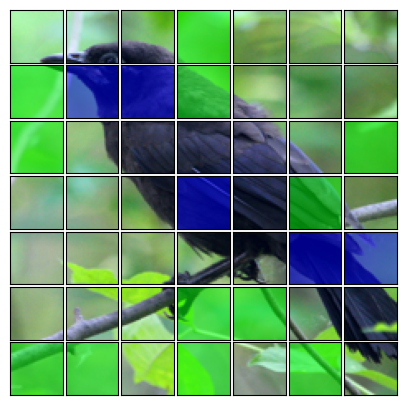

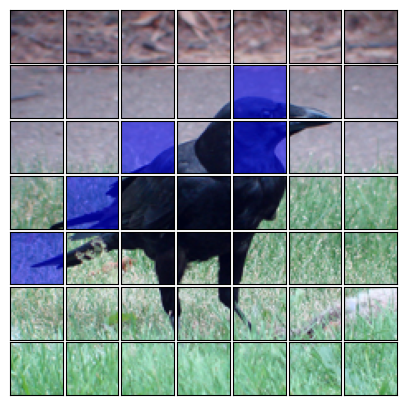

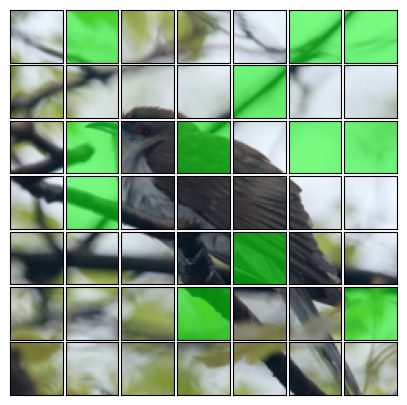

In [12]:
#@title plot patches with best buddies


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [13]:
#@title STEP 2: find foreground and remove best buddies beloning to background

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
# The following variable is important for the thresholding. You either set it to 0 or 1.
# In the more complete code this happens automatically as you will see later.
pca_component_to_threshold = 1
pca_features = pca.fit_transform(np.concatenate(embedings))

threshold = np.mean(pca_features[:, pca_component_to_threshold])
foreground_mask = pca_features[:, pca_component_to_threshold] > threshold+0.5*np.std(pca_features[:, pca_component_to_threshold])
foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)

prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

print(sum(best_buddies))

best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])
best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

print(sum(best_buddies))

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]


17
5


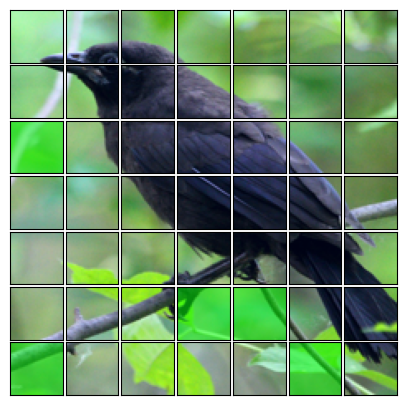

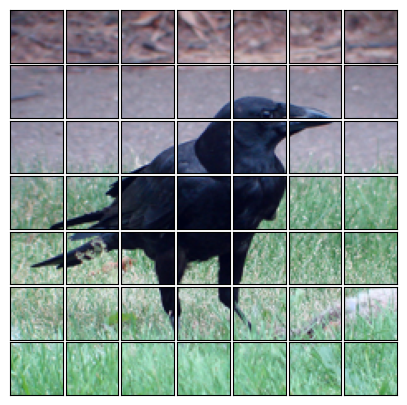

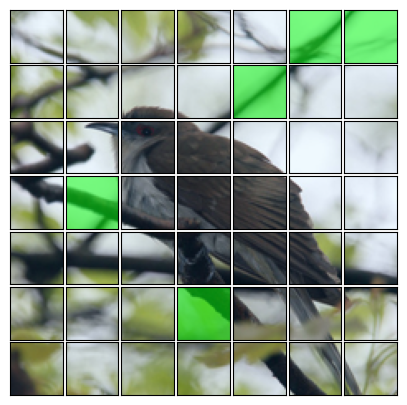

In [14]:
#@title plot patches with best buddies and background masked out


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [15]:
#@title STEP 3: cluster best buddies


NUMBER_OF_PAIRS = 5 # This determines the number of clusters

bb_query = embedings[0][best_buddies, :]
bb_prototypes = np.concatenate(embedings[1:])[nearest_neighbor_query[best_buddies], :]

bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=NUMBER_OF_PAIRS, random_state=0, n_init=10).fit(bb_combined_patches)
indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
query_indices_to_show = np.arange(NUMBER_OF_PATCHES)[indices_to_show]
prototype_indices_to_show = nearest_neighbor_query[indices_to_show]


print(query_indices_to_show)
print(prototype_indices_to_show)


[39 42 38 14 47]
[60 71 87 55 54]


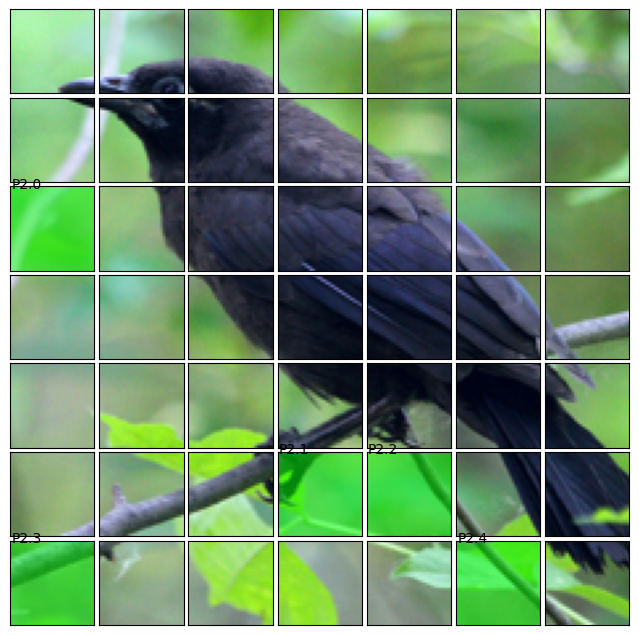

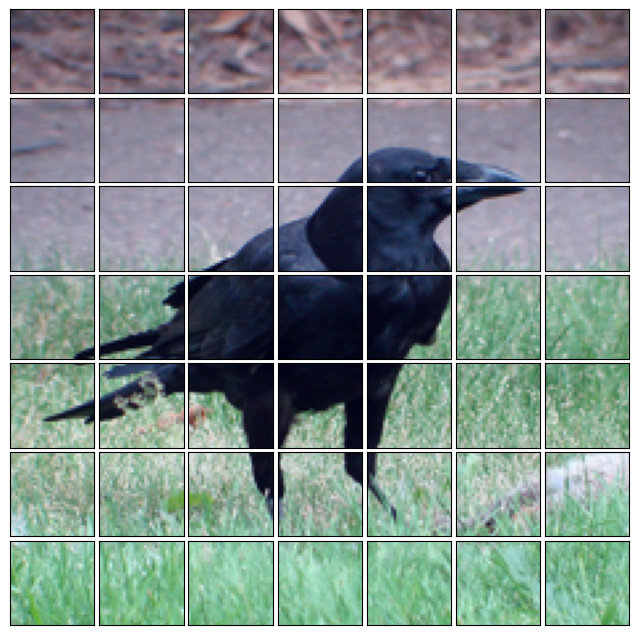

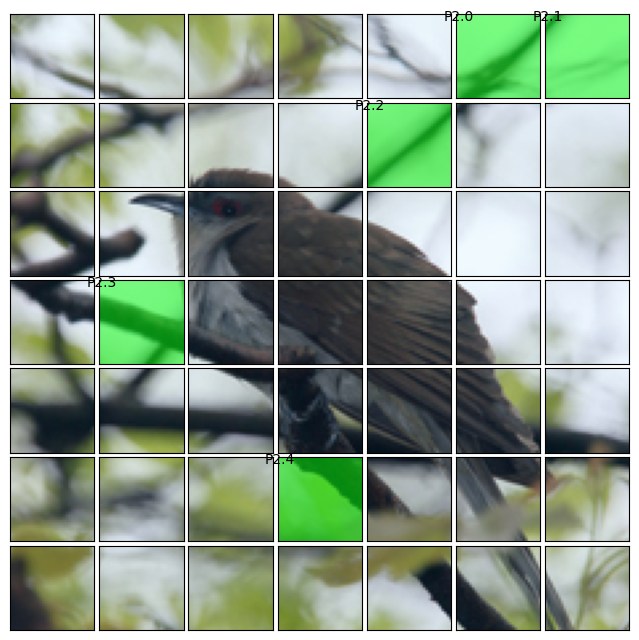

In [16]:
#@title plot query and prototypes with keypoints

for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in query_indices_to_show:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.0, 0.0, f"P2.{best_buddy_counter}")
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                    axs[row_idx, col_idx].text(0.4, 0.5, f"P1.{best_buddy_counter}")

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.3, 0.0, f"P1.{best_buddy_counter}")
                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.5, 0.5, f"P2.{best_buddy_counter}", horizontalalignment='center', verticalalignment='center')
                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




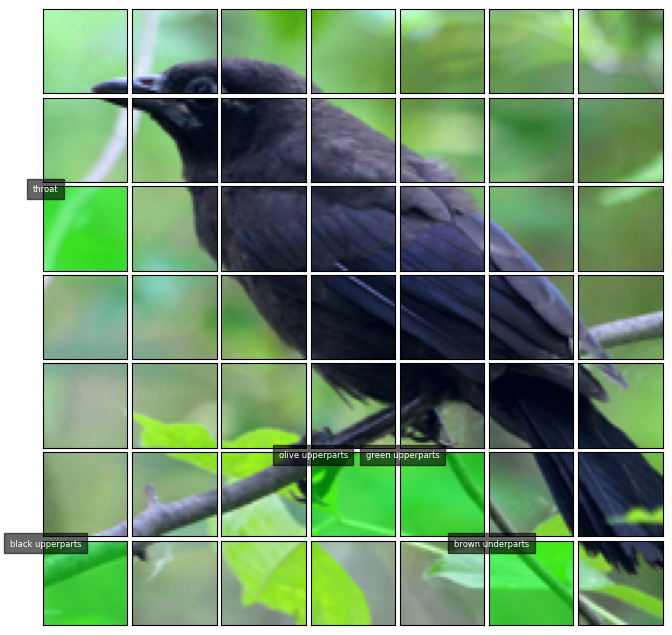

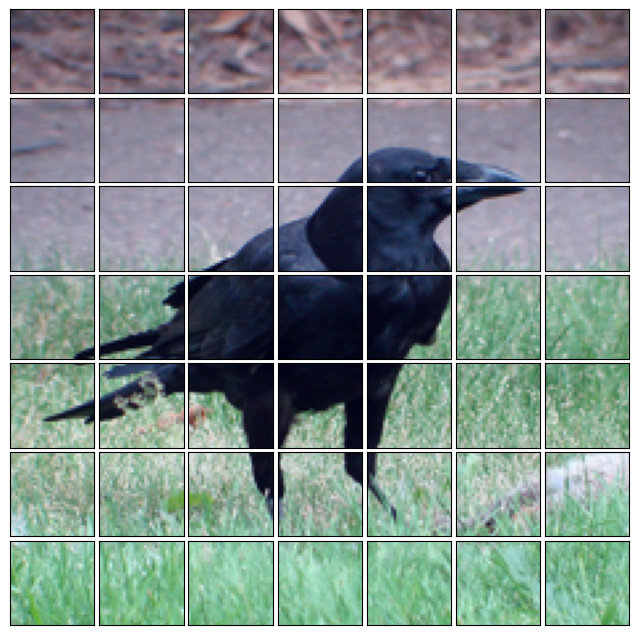

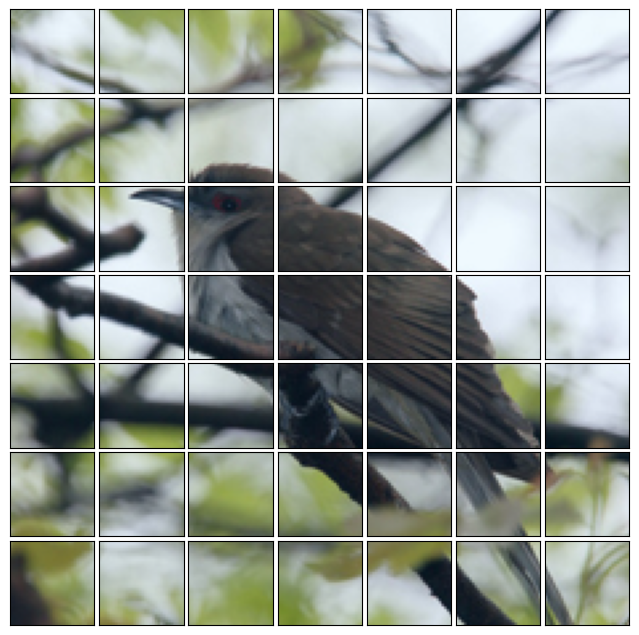

In [17]:
for counter, img in enumerate(inputs):

    img = img.permute(1, 2, 0)  # Rearrange to HWC format for visualization

    H, W, C = img.shape

    # Generate dummy input for patch calculation
    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    # Calculate number of patches
    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    # Crop image to match patch grid
    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    # Convert image into patches
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    # Create the plot
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))
    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0 and n_rows * row_idx + col_idx in best_buddies_query_indices:
                # Ensure the index is valid for the parts list
                if best_buddy_counter < len(best_buddies_query_indices):
                    current_index = best_buddies_query_indices[best_buddy_counter]
                    # the following label matches is totally wrong, it should find the corrsponding label from the matched_labels.
                    if current_index < len(parts):  # Check bounds
                        # Retrieve the part label for the best buddy
                        part_label = parts[current_index]

                        # Green shading for query
                        color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                        color_shading[:, :, 1] = 255  # Green shading
                        axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                        axs[row_idx, col_idx].text(
                            0.5, 0.5, part_label, horizontalalignment='center', verticalalignment='center',
                            color='white', fontsize=6, bbox=dict(facecolor="black", alpha=0.6)
                        )
                    else:
                        print(f"Skipping invalid index: {current_index}")
                    best_buddy_counter += 1

            if counter == 1 and n_rows * row_idx + col_idx in prototype_indices_to_show:
                if best_buddy_counter < len(prototype_indices_to_show):
                    current_index = prototype_indices_to_show[best_buddy_counter]
                    if current_index < len(parts):  # Check bounds
                        # Retrieve the part label for the prototype
                        part_label = parts[current_index]

                        # Blue shading for prototype
                        color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                        color_shading[:, :, 2] = 255  # Blue shading
                        axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                        axs[row_idx, col_idx].text(
                            0.5, 0.5, part_label, horizontalalignment='center', verticalalignment='center',
                            color='white', fontsize=6, bbox=dict(facecolor="black", alpha=0.6)
                        )
                    else:
                        print(f"Skipping invalid index: {current_index}")
                    best_buddy_counter += 1

    # Remove ticks and adjust spacing
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=0.05, hspace=0.05)